# Cox-Ingersoll-Ross (CIR) Model

## Introduction

The **Cox-Ingersoll-Ross (CIR) model** is a mathematical model used in finance to describe the evolution of interest rates. Developed by John C. Cox, Jonathan E. Ingersoll, and Stephen A. Ross in 1985, this model is a foundational tool in fixed-income analysis, derivative pricing, and risk management.

The CIR model belongs to the family of **mean-reverting stochastic processes** and is particularly notable for ensuring that interest rates remain non-negative—a critical property for realistic financial modeling.

## Mathematical Formulation

### The Stochastic Differential Equation

The CIR model describes the instantaneous interest rate $r_t$ through the following stochastic differential equation (SDE):

$$dr_t = \kappa(\theta - r_t)dt + \sigma\sqrt{r_t}\,dW_t$$

where:
- $r_t$ is the instantaneous interest rate at time $t$
- $\kappa > 0$ is the **speed of mean reversion** (rate at which $r_t$ reverts to $\theta$)
- $\theta > 0$ is the **long-term mean** (equilibrium level of the interest rate)
- $\sigma > 0$ is the **volatility coefficient**
- $W_t$ is a standard Wiener process (Brownian motion)

### Key Properties

#### 1. Mean Reversion

The drift term $\kappa(\theta - r_t)$ ensures mean reversion:
- When $r_t < \theta$: drift is positive, pushing rates upward
- When $r_t > \theta$: drift is negative, pushing rates downward

#### 2. Non-Negativity (Feller Condition)

The CIR model guarantees that $r_t \geq 0$ for all $t \geq 0$ if the **Feller condition** is satisfied:

$$2\kappa\theta \geq \sigma^2$$

This condition ensures the drift is strong enough to prevent the process from reaching zero.

#### 3. Stationary Distribution

As $t \to \infty$, the process converges to a **Gamma distribution** with:
- Shape parameter: $\alpha = \frac{2\kappa\theta}{\sigma^2}$
- Scale parameter: $\beta = \frac{\sigma^2}{2\kappa}$

The stationary mean is $\theta$ and variance is $\frac{\theta\sigma^2}{2\kappa}$.

### Conditional Distribution

Given $r_t$, the conditional distribution of $r_{t+\Delta t}$ follows a **non-central chi-squared distribution**:

$$r_{t+\Delta t} = \frac{\sigma^2(1-e^{-\kappa\Delta t})}{4\kappa} \chi^2_d(\lambda)$$

where:
- $d = \frac{4\kappa\theta}{\sigma^2}$ (degrees of freedom)
- $\lambda = \frac{4\kappa e^{-\kappa\Delta t}}{\sigma^2(1-e^{-\kappa\Delta t})} r_t$ (non-centrality parameter)

### Moments

The conditional expectation and variance are:

$$\mathbb{E}[r_{t+\Delta t} | r_t] = r_t e^{-\kappa\Delta t} + \theta(1 - e^{-\kappa\Delta t})$$

$$\text{Var}[r_{t+\Delta t} | r_t] = r_t \frac{\sigma^2}{\kappa}(e^{-\kappa\Delta t} - e^{-2\kappa\Delta t}) + \frac{\theta\sigma^2}{2\kappa}(1 - e^{-\kappa\Delta t})^2$$

## Numerical Simulation Methods

### Euler-Maruyama Scheme

The simplest discretization:

$$r_{t+\Delta t} = r_t + \kappa(\theta - r_t)\Delta t + \sigma\sqrt{r_t}\sqrt{\Delta t}\,Z$$

where $Z \sim \mathcal{N}(0, 1)$.

**Note:** This scheme can produce negative values. A common fix is to use $\sqrt{\max(r_t, 0)}$ or reflect at zero.

### Milstein Scheme

A higher-order scheme with improved convergence:

$$r_{t+\Delta t} = r_t + \kappa(\theta - r_t)\Delta t + \sigma\sqrt{r_t}\sqrt{\Delta t}\,Z + \frac{\sigma^2}{4}\Delta t(Z^2 - 1)$$

### Exact Simulation

Using the non-central chi-squared distribution provides exact samples without discretization error.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Set random seed for reproducibility
np.random.seed(42)

# CIR Model Parameters
kappa = 0.5      # Speed of mean reversion
theta = 0.05     # Long-term mean (5%)
sigma = 0.1      # Volatility
r0 = 0.03        # Initial interest rate (3%)

# Simulation parameters
T = 10.0         # Total time (years)
N = 10000        # Number of time steps
dt = T / N       # Time step size
n_paths = 5      # Number of sample paths

# Check Feller condition
feller_condition = 2 * kappa * theta >= sigma**2
print(f"CIR Model Parameters:")
print(f"  κ (mean reversion speed) = {kappa}")
print(f"  θ (long-term mean) = {theta:.2%}")
print(f"  σ (volatility) = {sigma}")
print(f"  r₀ (initial rate) = {r0:.2%}")
print(f"\nFeller condition (2κθ ≥ σ²): {2*kappa*theta:.4f} ≥ {sigma**2:.4f}")
print(f"Feller condition satisfied: {feller_condition}")

CIR Model Parameters:
  κ (mean reversion speed) = 0.5
  θ (long-term mean) = 5.00%
  σ (volatility) = 0.1
  r₀ (initial rate) = 3.00%

Feller condition (2κθ ≥ σ²): 0.0500 ≥ 0.0100
Feller condition satisfied: True


In [2]:
def simulate_cir_euler(r0, kappa, theta, sigma, T, N, n_paths=1):
    """
    Simulate CIR process using Euler-Maruyama scheme with reflection at zero.
    
    Parameters:
    -----------
    r0 : float
        Initial interest rate
    kappa : float
        Speed of mean reversion
    theta : float
        Long-term mean
    sigma : float
        Volatility coefficient
    T : float
        Total simulation time
    N : int
        Number of time steps
    n_paths : int
        Number of simulation paths
        
    Returns:
    --------
    t : ndarray
        Time grid
    r : ndarray
        Simulated interest rate paths (n_paths x N+1)
    """
    dt = T / N
    t = np.linspace(0, T, N + 1)
    r = np.zeros((n_paths, N + 1))
    r[:, 0] = r0
    
    # Generate random increments
    dW = np.random.normal(0, np.sqrt(dt), (n_paths, N))
    
    for i in range(N):
        # Euler-Maruyama step with reflection at zero
        r_current = np.maximum(r[:, i], 0)
        drift = kappa * (theta - r_current) * dt
        diffusion = sigma * np.sqrt(r_current) * dW[:, i]
        r[:, i + 1] = np.abs(r_current + drift + diffusion)  # Reflection scheme
    
    return t, r


def simulate_cir_exact(r0, kappa, theta, sigma, T, N, n_paths=1):
    """
    Simulate CIR process using exact non-central chi-squared distribution.
    
    This method produces exact samples without discretization error.
    """
    dt = T / N
    t = np.linspace(0, T, N + 1)
    r = np.zeros((n_paths, N + 1))
    r[:, 0] = r0
    
    # Precompute constants
    exp_kdt = np.exp(-kappa * dt)
    c = sigma**2 * (1 - exp_kdt) / (4 * kappa)
    d = 4 * kappa * theta / sigma**2  # degrees of freedom
    
    for i in range(N):
        # Non-centrality parameter
        lambda_nc = r[:, i] * exp_kdt / c
        # Sample from non-central chi-squared
        r[:, i + 1] = c * np.random.noncentral_chisquare(d, lambda_nc)
    
    return t, r


# Simulate multiple paths using both methods
t, r_euler = simulate_cir_euler(r0, kappa, theta, sigma, T, N, n_paths)
t, r_exact = simulate_cir_exact(r0, kappa, theta, sigma, T, N, n_paths)

print(f"Simulation complete: {n_paths} paths over {T} years with {N} steps")

Simulation complete: 5 paths over 10.0 years with 10000 steps


In [3]:
# Calculate theoretical moments
def theoretical_mean(r0, kappa, theta, t):
    """Conditional expectation E[r_t | r_0]"""
    return r0 * np.exp(-kappa * t) + theta * (1 - np.exp(-kappa * t))

def theoretical_variance(r0, kappa, theta, sigma, t):
    """Conditional variance Var[r_t | r_0]"""
    exp_kt = np.exp(-kappa * t)
    term1 = r0 * (sigma**2 / kappa) * (exp_kt - np.exp(-2 * kappa * t))
    term2 = (theta * sigma**2 / (2 * kappa)) * (1 - exp_kt)**2
    return term1 + term2

# Compute theoretical curves
mean_theory = theoretical_mean(r0, kappa, theta, t)
var_theory = theoretical_variance(r0, kappa, theta, sigma, t)
std_theory = np.sqrt(var_theory)

# Compute sample statistics from exact simulation (many paths)
n_monte_carlo = 1000
_, r_mc = simulate_cir_exact(r0, kappa, theta, sigma, T, N, n_monte_carlo)
mean_sample = np.mean(r_mc, axis=0)
std_sample = np.std(r_mc, axis=0)

print(f"Monte Carlo simulation with {n_monte_carlo} paths complete")
print(f"\nStationary distribution properties:")
print(f"  Theoretical mean: {theta:.4f}")
print(f"  Theoretical variance: {theta * sigma**2 / (2 * kappa):.6f}")
print(f"  Sample mean at t={T}: {mean_sample[-1]:.4f}")
print(f"  Sample std at t={T}: {std_sample[-1]:.4f}")

Monte Carlo simulation with 1000 paths complete

Stationary distribution properties:
  Theoretical mean: 0.0500
  Theoretical variance: 0.000500
  Sample mean at t=10.0: 0.0479
  Sample std at t=10.0: 0.0210


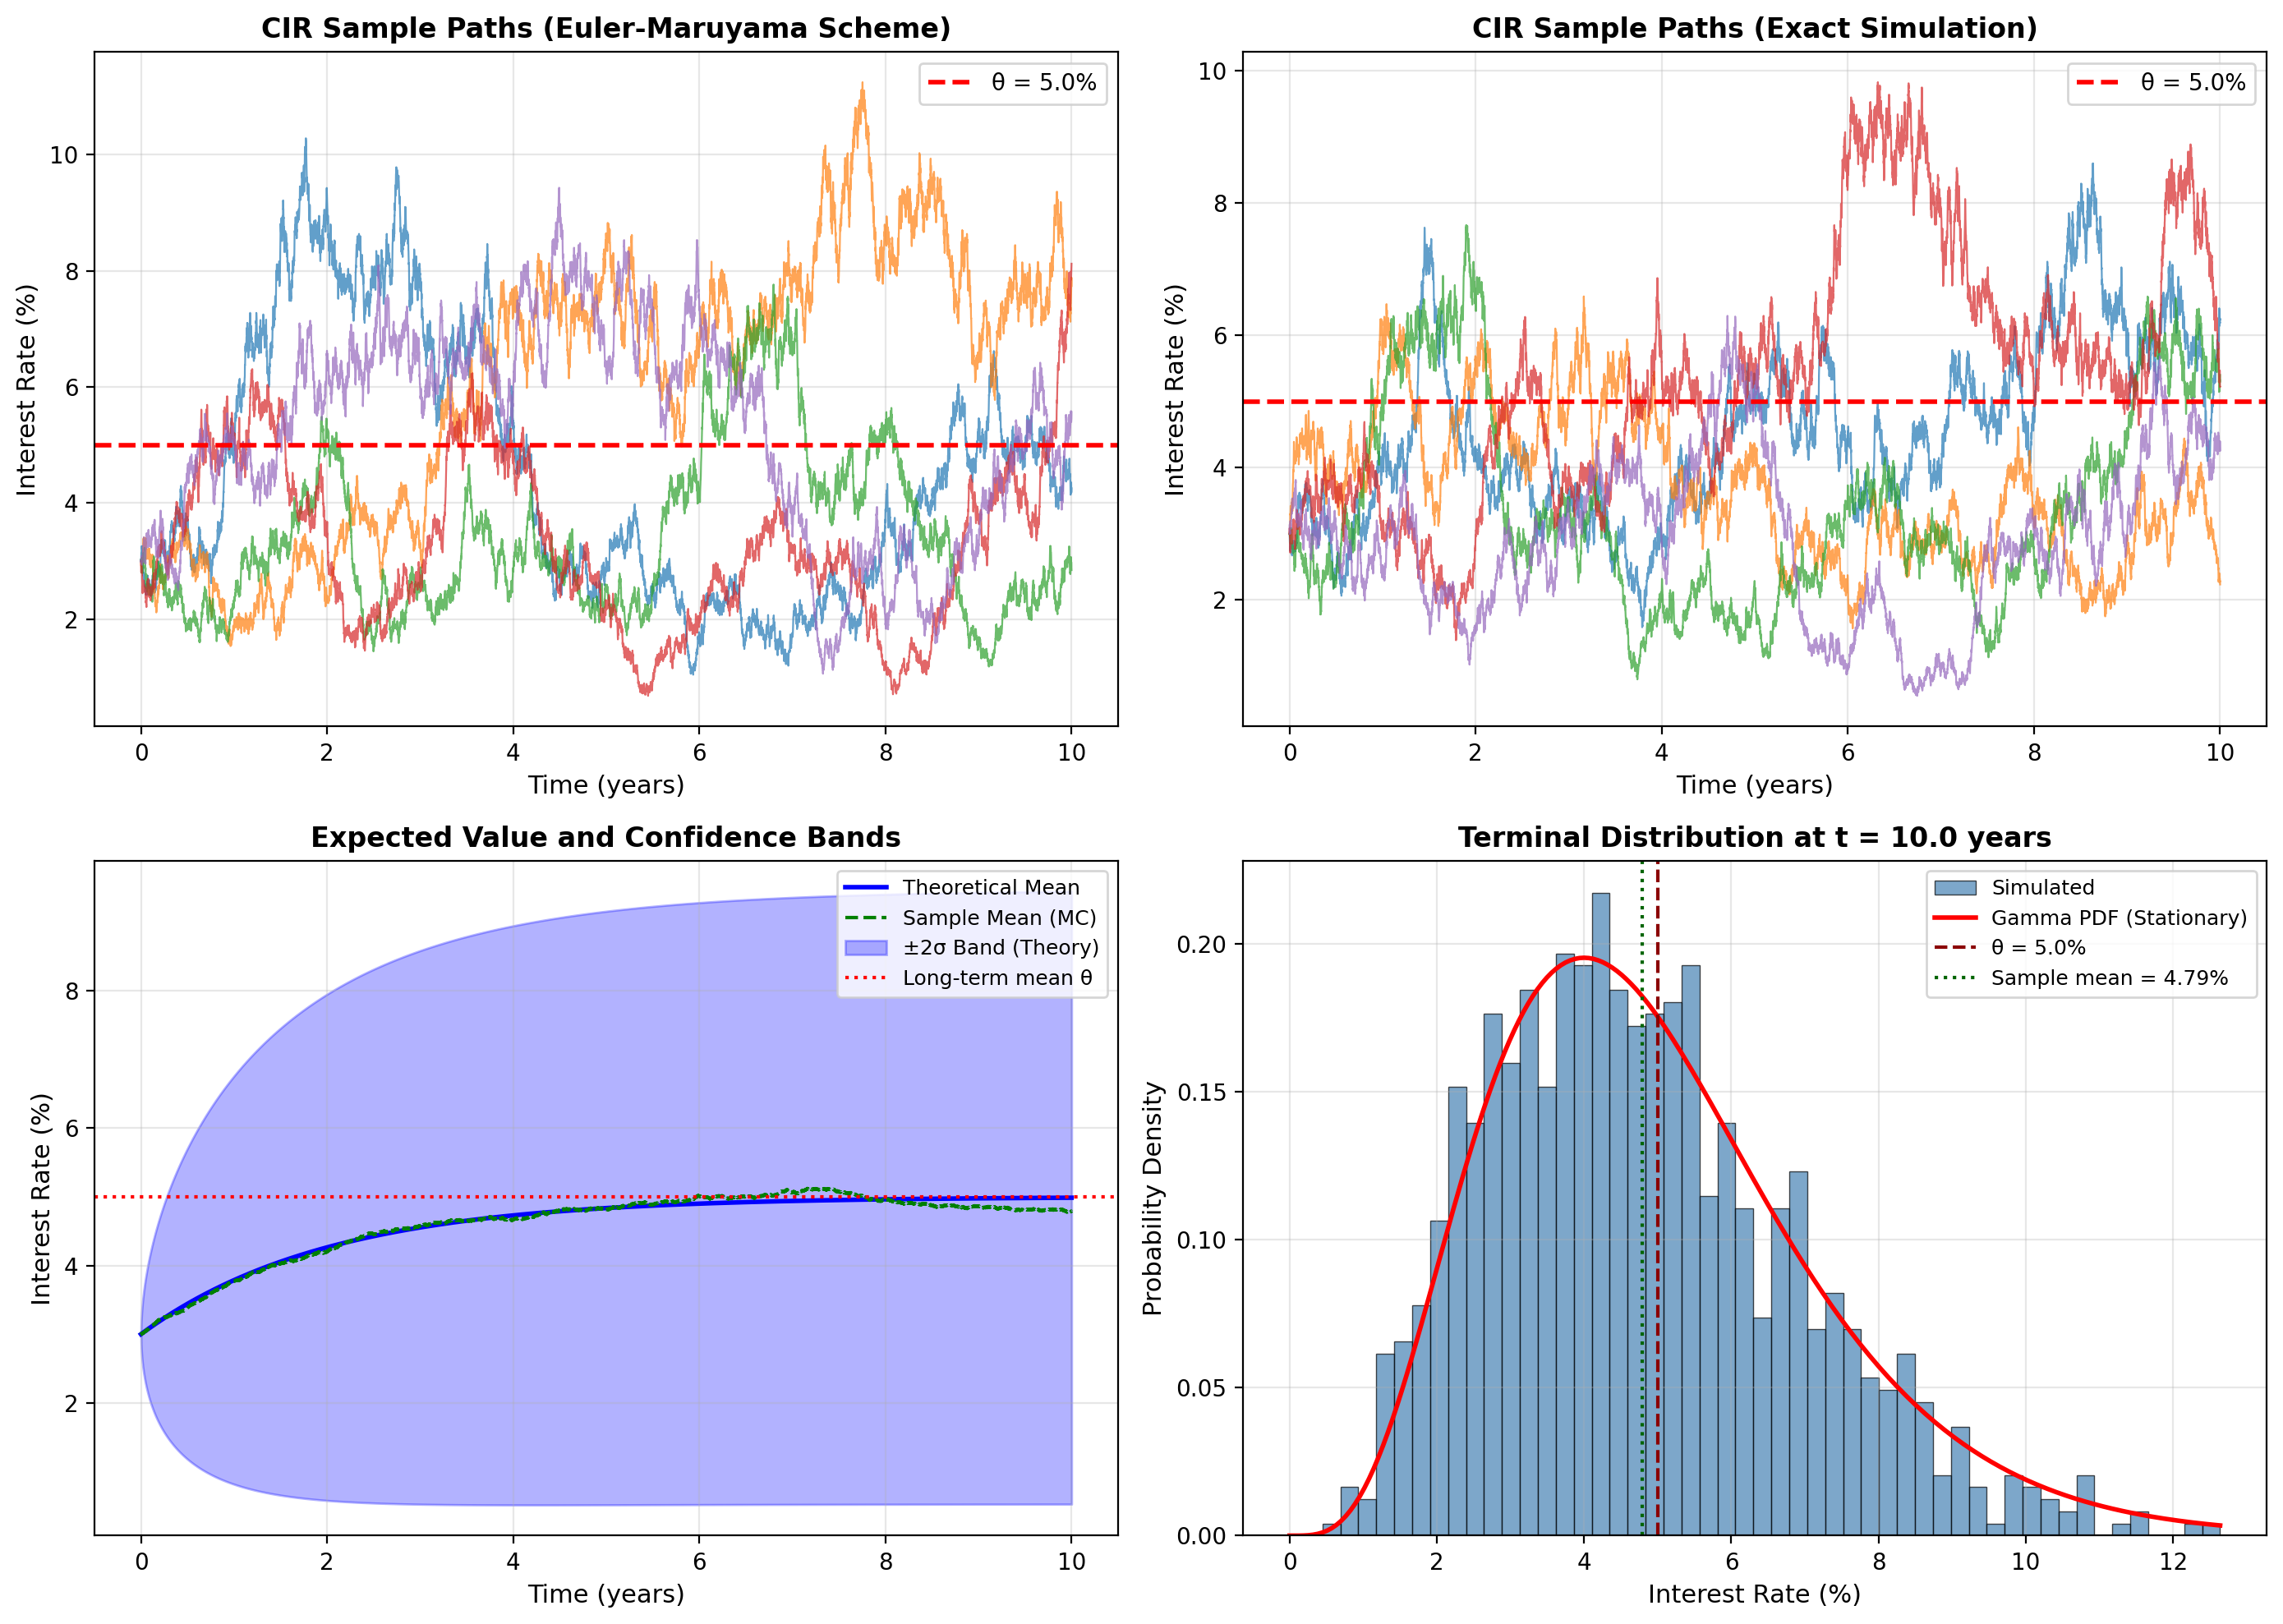


Plot saved to 'plot.png'


In [4]:
# Create comprehensive visualization
fig = plt.figure(figsize=(14, 10))

# Plot 1: Sample paths with Euler scheme
ax1 = fig.add_subplot(2, 2, 1)
for i in range(n_paths):
    ax1.plot(t, r_euler[i, :] * 100, alpha=0.7, linewidth=0.8)
ax1.axhline(y=theta * 100, color='red', linestyle='--', linewidth=2, label=f'θ = {theta:.1%}')
ax1.set_xlabel('Time (years)', fontsize=11)
ax1.set_ylabel('Interest Rate (%)', fontsize=11)
ax1.set_title('CIR Sample Paths (Euler-Maruyama Scheme)', fontsize=12, fontweight='bold')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Plot 2: Sample paths with exact simulation
ax2 = fig.add_subplot(2, 2, 2)
for i in range(n_paths):
    ax2.plot(t, r_exact[i, :] * 100, alpha=0.7, linewidth=0.8)
ax2.axhline(y=theta * 100, color='red', linestyle='--', linewidth=2, label=f'θ = {theta:.1%}')
ax2.set_xlabel('Time (years)', fontsize=11)
ax2.set_ylabel('Interest Rate (%)', fontsize=11)
ax2.set_title('CIR Sample Paths (Exact Simulation)', fontsize=12, fontweight='bold')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

# Plot 3: Mean and confidence bands
ax3 = fig.add_subplot(2, 2, 3)
ax3.plot(t, mean_theory * 100, 'b-', linewidth=2, label='Theoretical Mean')
ax3.plot(t, mean_sample * 100, 'g--', linewidth=1.5, label='Sample Mean (MC)')
ax3.fill_between(t, 
                  (mean_theory - 2*std_theory) * 100, 
                  (mean_theory + 2*std_theory) * 100, 
                  alpha=0.3, color='blue', label='±2σ Band (Theory)')
ax3.axhline(y=theta * 100, color='red', linestyle=':', linewidth=1.5, label=f'Long-term mean θ')
ax3.set_xlabel('Time (years)', fontsize=11)
ax3.set_ylabel('Interest Rate (%)', fontsize=11)
ax3.set_title('Expected Value and Confidence Bands', fontsize=12, fontweight='bold')
ax3.legend(loc='upper right', fontsize=9)
ax3.grid(True, alpha=0.3)

# Plot 4: Terminal distribution
ax4 = fig.add_subplot(2, 2, 4)
terminal_rates = r_mc[:, -1] * 100

# Histogram of simulated terminal rates
ax4.hist(terminal_rates, bins=50, density=True, alpha=0.7, color='steelblue', 
         edgecolor='black', linewidth=0.5, label='Simulated')

# Theoretical Gamma distribution for stationary distribution
shape = 2 * kappa * theta / sigma**2
scale = sigma**2 / (2 * kappa) * 100  # Convert to percentage
x_gamma = np.linspace(0, max(terminal_rates), 200)
pdf_gamma = stats.gamma.pdf(x_gamma, a=shape, scale=scale)
ax4.plot(x_gamma, pdf_gamma, 'r-', linewidth=2, label='Gamma PDF (Stationary)')

ax4.axvline(x=theta * 100, color='darkred', linestyle='--', linewidth=1.5, 
            label=f'θ = {theta:.1%}')
ax4.axvline(x=np.mean(terminal_rates), color='darkgreen', linestyle=':', linewidth=1.5,
            label=f'Sample mean = {np.mean(terminal_rates):.2f}%')
ax4.set_xlabel('Interest Rate (%)', fontsize=11)
ax4.set_ylabel('Probability Density', fontsize=11)
ax4.set_title(f'Terminal Distribution at t = {T} years', fontsize=12, fontweight='bold')
ax4.legend(loc='upper right', fontsize=9)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('cox_ingersoll_ross_model_analysis.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print("\nPlot saved to 'plot.png'")

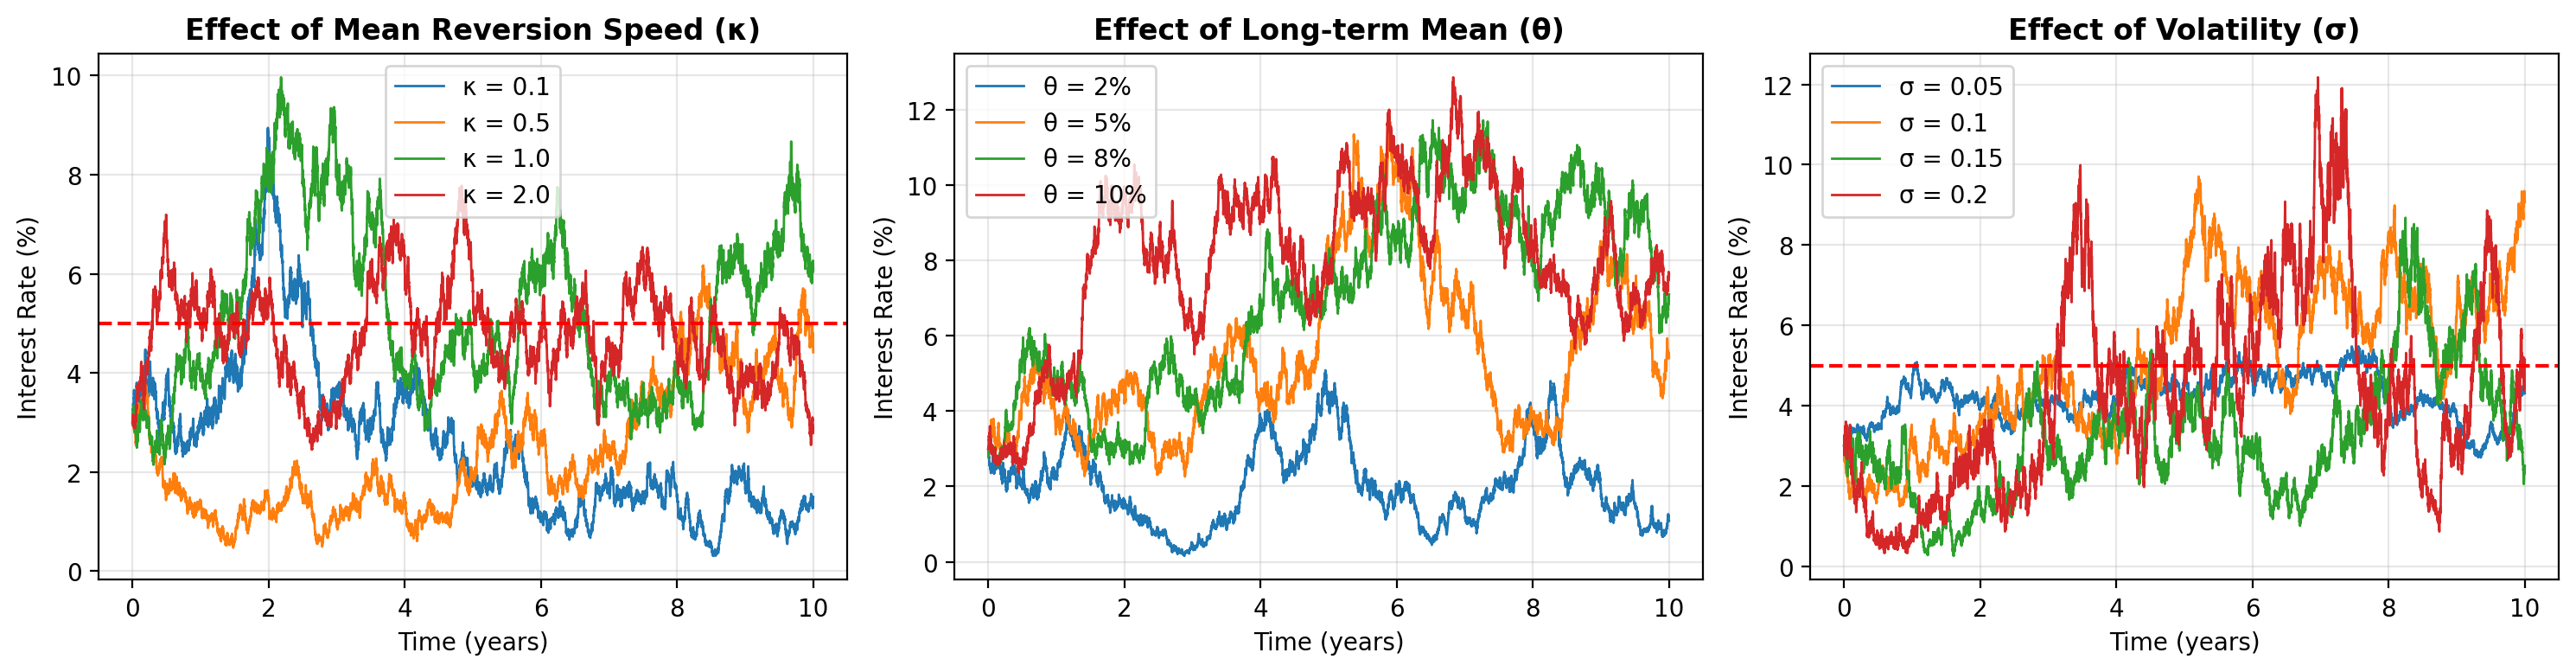

Parameter sensitivity analysis complete


In [5]:
# Parameter sensitivity analysis
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Sensitivity to kappa (mean reversion speed)
kappa_values = [0.1, 0.5, 1.0, 2.0]
ax = axes[0]
for k in kappa_values:
    _, r_temp = simulate_cir_exact(r0, k, theta, sigma, T, N, 1)
    ax.plot(t, r_temp[0, :] * 100, label=f'κ = {k}', linewidth=1)
ax.axhline(y=theta * 100, color='red', linestyle='--', linewidth=1.5)
ax.set_xlabel('Time (years)')
ax.set_ylabel('Interest Rate (%)')
ax.set_title('Effect of Mean Reversion Speed (κ)', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Sensitivity to theta (long-term mean)
theta_values = [0.02, 0.05, 0.08, 0.10]
ax = axes[1]
for th in theta_values:
    _, r_temp = simulate_cir_exact(r0, kappa, th, sigma, T, N, 1)
    ax.plot(t, r_temp[0, :] * 100, label=f'θ = {th:.0%}', linewidth=1)
ax.set_xlabel('Time (years)')
ax.set_ylabel('Interest Rate (%)')
ax.set_title('Effect of Long-term Mean (θ)', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Sensitivity to sigma (volatility)
sigma_values = [0.05, 0.10, 0.15, 0.20]
ax = axes[2]
for s in sigma_values:
    _, r_temp = simulate_cir_exact(r0, kappa, theta, s, T, N, 1)
    ax.plot(t, r_temp[0, :] * 100, label=f'σ = {s}', linewidth=1)
ax.axhline(y=theta * 100, color='red', linestyle='--', linewidth=1.5)
ax.set_xlabel('Time (years)')
ax.set_ylabel('Interest Rate (%)')
ax.set_title('Effect of Volatility (σ)', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Parameter sensitivity analysis complete")

## Applications and Extensions

### Financial Applications

1. **Bond Pricing**: The CIR model admits a closed-form solution for zero-coupon bond prices:
   $$P(t, T) = A(t, T) e^{-B(t, T) r_t}$$
   where $A$ and $B$ are known functions of the parameters.

2. **Option Pricing**: Used to price interest rate derivatives such as caps, floors, and swaptions.

3. **Credit Risk**: Extended to model default intensities in reduced-form credit models.

4. **Stochastic Volatility**: The CIR process is used in the Heston model for variance dynamics.

### Model Limitations

- **Single factor**: Cannot capture complex term structure dynamics
- **Constant parameters**: Assumes time-homogeneous behavior
- **Calibration challenges**: May not fit all market conditions perfectly

### Extensions

- **Multi-factor CIR**: Multiple correlated CIR processes
- **Time-dependent parameters**: CIR++ model with time-varying $\theta(t)$
- **Jump-diffusion extensions**: Adding jumps for sudden rate changes

## Summary

The Cox-Ingersoll-Ross model provides a theoretically sound and practically useful framework for modeling interest rates. Its key strengths are:

1. **Non-negativity**: Rates cannot become negative (under Feller condition)
2. **Mean reversion**: Realistic long-term behavior
3. **Analytical tractability**: Closed-form solutions for many quantities
4. **Exact simulation**: Available via non-central chi-squared distribution

The model remains a cornerstone of quantitative finance and serves as a building block for more sophisticated interest rate models.